In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score
from fairlearn.metrics import (selection_rate_difference, 
                               false_negative_rate_difference,
                               equalized_odds_difference,
                               false_negative_rate
                               )
from fairlearn.metrics import MetricFrame

In [2]:
test_df = pd.read_csv('val.csv')
true_labels = test_df.smoking
test_df = test_df.drop('smoking', axis=1)

# proprocessing steps from the original notebook

In [8]:
def create_extra_features(df):
    # order the ears
    best = np.where(df['hearing(left)'] < df['hearing(right)'], 
                    df['hearing(left)'],  df['hearing(right)'])
    worst = np.where(df['hearing(left)'] < df['hearing(right)'], 
                     df['hearing(right)'],  df['hearing(left)'])
    df['hearing(left)'] = best - 1
    df['hearing(right)'] = worst - 1
    
    # order the eyes - eyesight is worst to best, and 9+ should be worst!
    df['eyesight(left)'] = np.where(df['eyesight(left)'] > 9, 0, df['eyesight(left)'])
    df['eyesight(right)'] = np.where(df['eyesight(right)'] > 9, 0, df['eyesight(right)'])
    best = np.where(df['eyesight(left)'] < df['eyesight(right)'], 
                    df['eyesight(left)'],  df['eyesight(right)'])
    worst = np.where(df['eyesight(left)'] < df['eyesight(right)'], 
                     df['eyesight(right)'],  df['eyesight(left)'])
    df['eyesight(left)'] = best
    df['eyesight(right)'] = worst
    ##
    df['Gtp'] = np.clip(df['Gtp'], 0, 300)
    df['HDL'] = np.clip(df['HDL'], 0, 110)
    df['LDL'] = np.clip(df['LDL'], 0, 200)
    df['ALT'] = np.clip(df['ALT'], 0, 150)
    df['AST'] = np.clip(df['AST'], 0, 100)
    df['serum creatinine'] = np.clip(df['serum creatinine'], 0, 3)   
    
create_extra_features(test_df)

In [ ]:
test_to_scale = test_df.drop(['id','hearing(left)', 'hearing(right)', 'Urine protein','dental caries'],axis =1)
test_to_ohe = test_df[['hearing(left)', 'hearing(right)', 'Urine protein','dental caries']]

In [10]:
from sklearn.preprocessing import RobustScaler

sc = RobustScaler()
sc.center_ = np.array([ 40. , 165. ,  65. ,  83. ,   0.9,   1. , 121. ,  78. ,  96. ,
        196. , 113. ,  54. , 114. ,  15. ,   0.9,  23. ,  22. ,  27. ])
sc.scale_ = np.array([15. , 10. , 20. , 12. ,  0.5,  0.3, 17. , 12. , 13. , 42. , 88. ,
        19. , 40. ,  2. ,  0.2,  9. , 16. , 26. ])

test_to_scale = test_df.drop(['hearing(left)', 'hearing(right)', 'Urine protein','dental caries'],axis =1)
test_to_ohe = test_df[['hearing(left)', 'hearing(right)', 'Urine protein','dental caries']]

scaled_test = pd.DataFrame(sc.transform(test_to_scale),columns = test_to_scale.columns)
ohe_test  = pd.get_dummies(test_to_ohe, columns = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries'])

ohe_test = ohe_test.reset_index(drop = True)
scaled_test  = scaled_test.reset_index(drop =True)

test_df = pd.concat([ohe_test,scaled_test],axis =1)

test_df.head()

/opt/anaconda3/envs/native/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


,hearing(left)_0,hearing(left)_1,hearing(right)_0,hearing(right)_1,Urine protein_1,Urine protein_2,Urine protein_3,Urine protein_4,Urine protein_5,Urine protein_6,...,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,serum creatinine,AST,ALT,Gtp
0,1,0,1,0,1,0,0,0,0,0,...,-1.846154,0.119048,0.715909,-0.315789,0.075,-0.30,0.0,1.000000,0.8750,-0.615385
1,1,0,1,0,0,1,0,0,0,0,...,-0.153846,0.523810,-0.727273,0.631579,0.700,-0.65,1.5,-0.111111,-0.3125,-0.384615
2,1,0,1,0,0,1,0,0,0,0,...,0.461538,0.857143,0.465909,-0.315789,0.975,1.20,1.5,0.000000,0.5000,-0.307692
3,1,0,1,0,1,0,0,0,0,0,...,-0.461538,-0.952381,-0.579545,0.526316,-0.875,0.65,1.0,-0.111111,0.2500,0.076923
4,1,0,1,0,0,1,0,0,0,0,...,-1.153846,-0.023810,0.193182,-0.052632,0.025,0.20,0.0,0.111111,1.0625,0.461538


## Loading the best xgboost model

In [11]:
model = pickle.load(open('xgboost_model_split.pkl', 'rb'))

/opt/anaconda3/envs/native/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:43:12] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:360: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/native/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:43:12] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:385: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)


In [12]:
prediction_proba = model.predict_proba(test_df)[:, -1]
test_df['risk'] = prediction_proba
test_df['prediction'] = np.where(test_df['risk'] > 0.5, 1, 0)
test_df['age'] = test_df['age'].apply(lambda x: "old" if x > 0 else "young")

## Explainability
- (1)The model feature importance -this is the global explainability of the model

- (2) SHAP waterfall plots for a TP, TN, FP, FN predicted by the model (recall the HW2 SHAP question)- this is for local explainability

- (3)A discussion of the above, ex. most important features are as expected sensitive features do or do not have high importance, features X,Y, and Z seem to be the most likely to result in a misclassification

### model feature importance

<Axes: xlabel='Value', ylabel='Feature'>

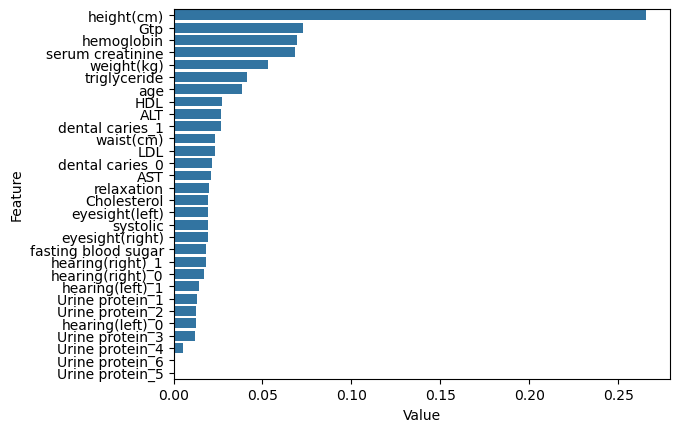

In [14]:
feature_importance = model.feature_importances_
feature_names = test_df.columns
feature_imp = pd.DataFrame(sorted(zip(feature_importance, feature_names), reverse=True), columns=['Value','Feature'])

sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))

### SHAP waterfall plots for a TP, TN, FP, FN predicted by the model (recall the HW2 SHAP question)- this is for local explainability

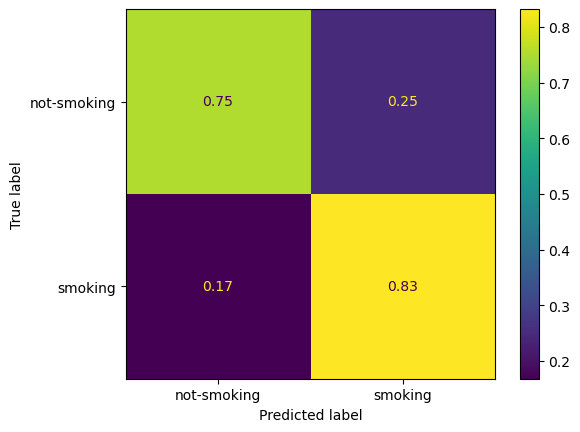

In [23]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import shap

cm = confusion_matrix(true_labels, test_df['prediction'], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not-smoking', 'smoking'])
disp.plot();


In [59]:
pred_and_true = pd.DataFrame({'prediction': test_df['prediction'], 'true': true_labels})
FN = pred_and_true[(pred_and_true['prediction'] == 0) & (pred_and_true['true'] == 1)].index
FP = pred_and_true[(pred_and_true['prediction'] == 1) & (pred_and_true['true'] == 0)].index
TP = pred_and_true[(pred_and_true['prediction'] == 1) & (pred_and_true['true'] == 1)].index
TN = pred_and_true[(pred_and_true['prediction'] == 0) & (pred_and_true['true'] == 0)].index

# randomly select 1 from each
FN_selected = np.random.choice(FN, 1)
FP_selected = np.random.choice(FP, 1)
TP_selected = np.random.choice(TP, 1)
TN_selected = np.random.choice(TN, 1)

In [60]:
explainer = shap.Explainer(model)
shape_vals = explainer(test_df.drop(['risk', 'prediction'], axis=1))

[13:18:59] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[13:19:06] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


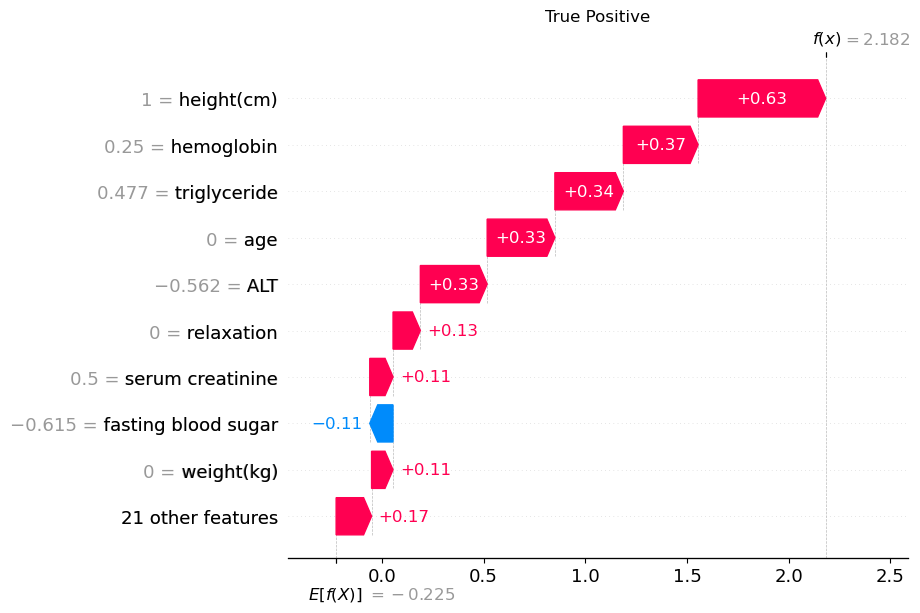

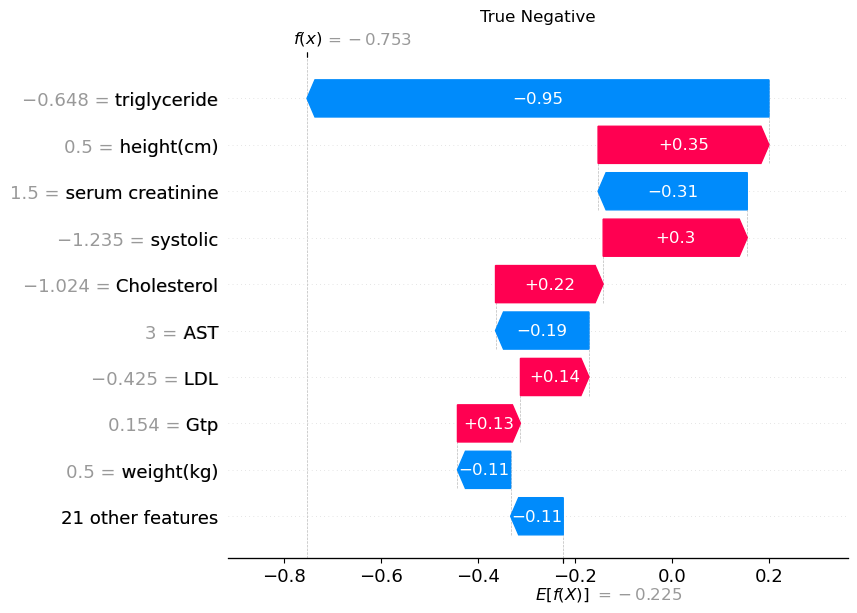

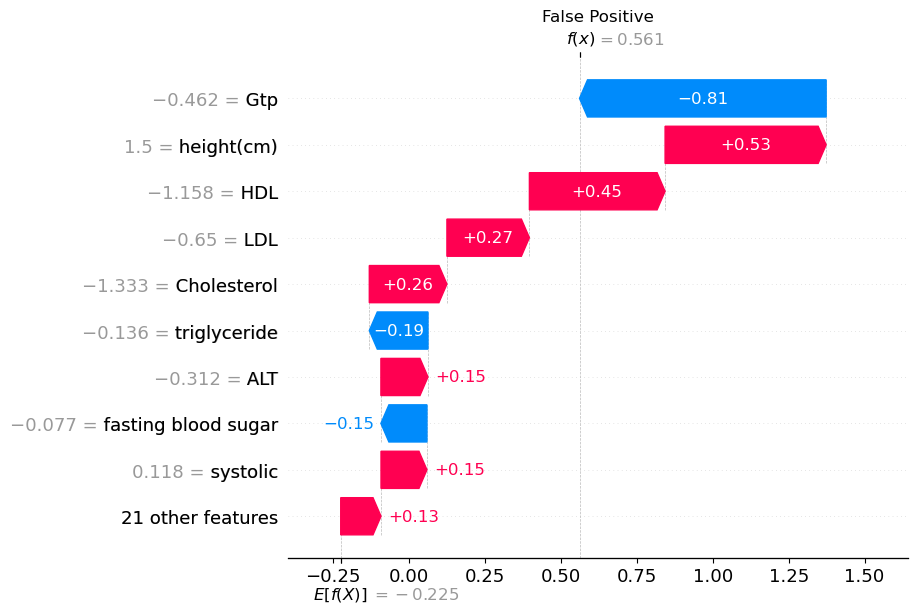

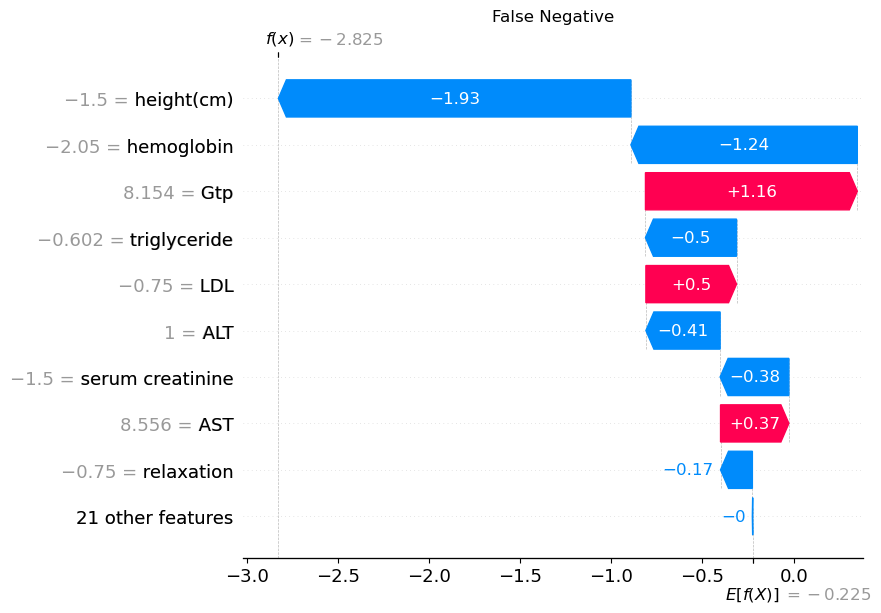

In [58]:
plt.title('True Positive')
shap.plots.waterfall(shape_vals[TP_selected[0]])

plt.title('True Negative')
shap.plots.waterfall(shape_vals[TN_selected[0]])

plt.title('False Positive')
shap.plots.waterfall(shape_vals[FP_selected[0]])

plt.title('False Negative')
shap.plots.waterfall(shape_vals[FN_selected[0]])


## Second, include a section on fairness, made up of two parts:
(1) Calculating fairness metrics for the sensitive features in your dataset. Pick at least 3 metrics (ex. Demographic parity, FNR/FPR disparity, EqualizedOdds, Accuracy difference between groups)

(2)A discussion of the above, ex. We did (or did not) find any bias with respect to metric X on sensitive feature Y. The real world implications of this could be X, Y, and z.

### (1) Calculating fairness metrics for the sensitive features in your dataset. Pick at least 3 metrics (ex. Demographic parity, FNR/FPR disparity, EqualizedOdds, Accuracy difference between groups)

- Accuracy metrics: Recall, Accuracy, FNR
- Fairness metrics: FNR difference, Equalized Odds difference, selection rate difference 

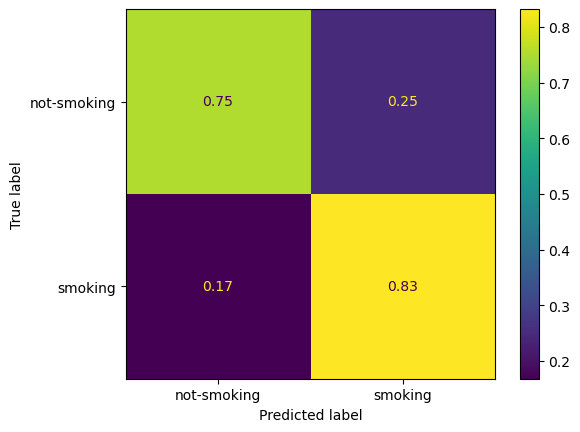

Recall: 0.832
Accuracy: 0.786
False Negative Rate: 0.168


In [72]:
# evaluate the model
conf_mat = confusion_matrix(true_labels, test_df['prediction'], normalize='true')
ConfusionMatrixDisplay(conf_mat, display_labels=['not-smoking', 'smoking']).plot()
plt.show()

# recall, accuracy, FNR
recall = recall_score(true_labels, test_df['prediction'])
accuracy = accuracy_score(true_labels, test_df['prediction'])
FNR = 1 - recall

print(f'Recall: {recall:.3f}')
print(f'Accuracy: {accuracy:.3f}')
print(f'False Negative Rate: {FNR:.3f}')

In [116]:
sensitive_features = test_df['age']

metric_dict = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'FNR': false_negative_rate,
    'false_negative_rate_difference': false_negative_rate_difference,
    'equalized_odds_difference': equalized_odds_difference,
    'selection_rate_difference': selection_rate_difference
}


sample_params = {
    'false_negative_rate_difference': {'sensitive_features': sensitive_features},
    'equalized_odds_difference': {'sensitive_features': sensitive_features},
    'selection_rate_difference': {'sensitive_features': sensitive_features},
}
        

metric_frame = MetricFrame(
    metrics = metric_dict,
    y_true = true_labels,
    y_pred = test_df['prediction'],
    sensitive_features = sensitive_features,
    sample_params = sample_params
    )

print("Overall metrics: ")
print("=" * 45)
print(metric_frame.overall)
print()
print("Metrics by group: ")
print("=" * 45)
print(metric_frame.by_group[['accuracy', 'precision', 'recall', 'FNR']])

Overall metrics: 
accuracy                          0.786252
precision                         0.711663
recall                            0.831810
FNR                               0.168190
false_negative_rate_difference    0.082884
equalized_odds_ratio              0.191494
selection_rate_difference         0.240562
dtype: float64

Metrics by group: 
       accuracy  precision    recall       FNR
age                                           
old    0.819677   0.710379  0.780080  0.219920
young  0.756079   0.712363  0.862965  0.137035


In [121]:
### Latex version of the above
print("Overall:")
print("=" * 45)
print(metric_frame.overall.to_latex())
print("By group:")
print("=" * 45)
print(metric_frame.by_group[['accuracy', 'precision', 'recall', 'FNR']].style.to_latex())

Overall:
\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
accuracy                       &  0.786252 \\
precision                      &  0.711663 \\
recall                         &  0.831810 \\
FNR                            &  0.168190 \\
false\_negative\_rate\_difference &  0.082884 \\
equalized\_odds\_ratio           &  0.191494 \\
selection\_rate\_difference      &  0.240562 \\
\bottomrule
\end{tabular}

By group:
\begin{tabular}{lrrrr}
 & accuracy & precision & recall & FNR \\
age &  &  &  &  \\
old & 0.819677 & 0.710379 & 0.780080 & 0.219920 \\
young & 0.756079 & 0.712363 & 0.862965 & 0.137035 \\
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


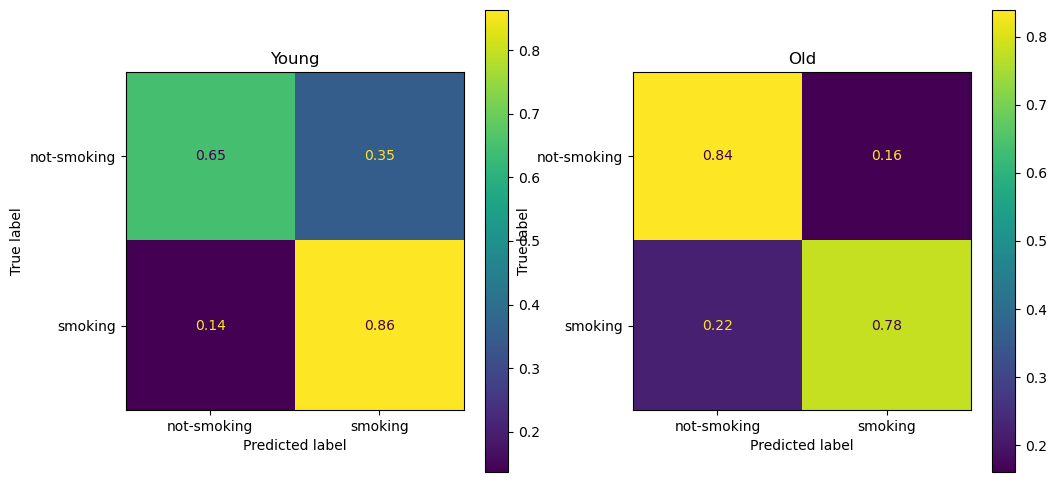

In [114]:
young_group = test_df[test_df['age'] == "young"].index
old_group = test_df[test_df['age'] == "old"].index

conf_young = confusion_matrix(true_labels[young_group], test_df['prediction'][young_group], normalize='true')
conf_old = confusion_matrix(true_labels[old_group], test_df['prediction'][old_group], normalize='true')


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(conf_young, display_labels=['not-smoking', 'smoking']).plot(ax=ax[0])
ax[0].set_title('Young')
ConfusionMatrixDisplay(conf_old, display_labels=['not-smoking', 'smoking']).plot(ax=ax[1])
ax[1].set_title('Old')
plt.show()